In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import deque

In [2]:
# Wandb
import wandb

wandb.init(project="Cartpole Vision RL")

wandb: Currently logged in as: arachne0. Use `wandb login --relogin` to force relogin


In [3]:
############ HYPERPARAMETERS ##############
BATCH_SIZE = 128 # original = 128
GAMMA = 0.999 # original = 0.999
EPS_START = 0.9 # original = 0.9
EPS_END = 0.01 # original = 0.05
EPS_DECAY = 3000 # original = 200
TARGET_UPDATE = 50 # original = 10
MEMORY_SIZE = 100000 # original = 10000
END_SCORE = 200 # 200 for Cartpole-v0
TRAINING_STOP = 142 # threshold for training stop
N_EPISODES = 50000 # total episodes to be run
LAST_EPISODES_NUM = 20 # number of episodes for stopping training
FRAMES = 2 # state is the number of last frames: the more frames, 
# the more the state is detailed (still Markovian)
RESIZE_PIXELS = 60 # Downsample image to this number of pixels

# ---- CONVOLUTIONAL NEURAL NETWORK ----
HIDDEN_LAYER_1 = 64
HIDDEN_LAYER_2 = 64 
HIDDEN_LAYER_3 = 32
KERNEL_SIZE = 5 # original = 5
STRIDE = 2 # original = 2
# --------------------------------------

GRAYSCALE = True # False is RGB
LOAD_MODEL = False # If we want to load the model, Default= False
USE_CUDA = True # If we want to use GPU (powerful one needed!)
############################################

In [4]:
graph_name = 'cartpole_vision'
device = torch.device("cuda" if (torch.cuda.is_available() and USE_CUDA) else "cpu")

In [5]:
# Settings for GRAYSCALE / RGB
if GRAYSCALE == 0:
    resize = T.Compose([T.ToPILImage(), 
                    T.Resize(RESIZE_PIXELS, interpolation=Image.BICUBIC),
                    T.ToTensor()])
    
    nn_inputs = 3*FRAMES  # number of channels for the nn
else:
    resize = T.Compose([T.ToPILImage(),
                    T.Resize(RESIZE_PIXELS, interpolation=Image.BICUBIC),
                    T.Grayscale(),
                    T.ToTensor()])
    nn_inputs =  FRAMES # number of channels for the nn

                    
stop_training = False 

env = gym.make("CartPole-v1", render_mode='rgb_array').unwrapped 

# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# If gpu is to be used

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [6]:
# Memory for Experience Replay
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None) # if we haven't reached full capacity, we append a new transition
        self.memory[self.position] = Transition(*args)  
        self.position = (self.position + 1) % self.capacity # e.g if the capacity is 100, and our position is now 101, we don't append to
        # position 101 (impossible), but to position 1 (its remainder), overwriting old data

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size) 

    def __len__(self): 
        return len(self.memory)

In [7]:
# Build CNN
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(nn_inputs, HIDDEN_LAYER_1, kernel_size=KERNEL_SIZE, stride=STRIDE) 
        self.bn1 = nn.BatchNorm2d(HIDDEN_LAYER_1)
        self.conv2 = nn.Conv2d(HIDDEN_LAYER_1, HIDDEN_LAYER_2, kernel_size=KERNEL_SIZE, stride=STRIDE)
        self.bn2 = nn.BatchNorm2d(HIDDEN_LAYER_2)
        self.conv3 = nn.Conv2d(HIDDEN_LAYER_2, HIDDEN_LAYER_3, kernel_size=KERNEL_SIZE, stride=STRIDE)
        self.bn3 = nn.BatchNorm2d(HIDDEN_LAYER_3)
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = KERNEL_SIZE, stride = STRIDE):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        nn.Dropout()
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [8]:
# Cart location for centering image crop
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

# Cropping, downsampling (and Grayscaling) image
def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render().transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

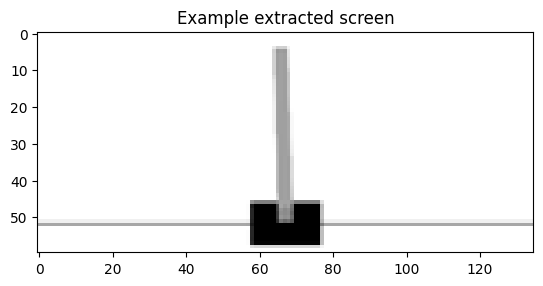

In [9]:
env.reset()
plt.figure()
if GRAYSCALE == 0:
    plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
            interpolation='none')
else:
    plt.imshow(get_screen().cpu().squeeze(0).permute(
        1, 2, 0).numpy().squeeze(), cmap='gray')
plt.title('Example extracted screen')
plt.show()

In [10]:
env.close()

In [11]:
eps_threshold = 0.9 # original = 0.9

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
print("Screen height: ", screen_height," | Width: ", screen_width)

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

if LOAD_MODEL == True:
    policy_net_checkpoint = torch.load('save_model/policy_net_best3.pt') # best 3 is the default best
    target_net_checkpoint = torch.load('save_model/target_net_best3.pt')
    policy_net.load_state_dict(policy_net_checkpoint)
    target_net.load_state_dict(target_net_checkpoint)
    policy_net.eval()
    target_net.eval()
    stop_training = True # if we want to load, then we don't train the network anymore

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(MEMORY_SIZE)

steps_done = 0


# Action selection , if stop training == True, only exploitation
def select_action(state, stop_training):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    # print('Epsilon = ', eps_threshold, end='\n')
    if sample > eps_threshold or stop_training:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

Screen height:  60  | Width:  135


In [12]:
# Plotting
def plot_durations(score):
    fig, ax = plt.subplots(figsize=(16,8))
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    episode_number = len(durations_t) 
    ax.set_title('Training...')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Duration')
    dur = durations_t.numpy()
    plt.style.use('seaborn') #Change/Remove This If you Want
#     ax.plot(dur, label= 'Score')
    ax.fill_between(np.linspace(1,episode_number,episode_number),
                    dur - dur.std(), dur + dur.std(), alpha=0.2)

    plt.hlines(195, 0, episode_number, colors='red', linestyles=':', label='Win Threshold')
    
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        last100_mean = means[episode_number -100].item()
        means = torch.cat((torch.zeros(99), means))
        ax.plot(means.numpy(), label= 'Last 100 mean')
        print('Episode: ', episode_number, ' | Score: ', score, '| Last 100 mean = ', last100_mean)
    ax.legend(loc='upper left')
    fig.savefig('plots/' + graph_name)
#     if is_ipython:
#         display.clear_output(wait=True)
#         display.display(plt.gcf())
    fig.show()

In [13]:
# Training 
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    # torch.cat concatenates tensor sequence
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward).type(torch.FloatTensor).to(device)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    plt.figure(2)
    wandb.log({'Loss:': loss})

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [14]:
episodes_trajectories = []
episodes_after_stop = 100

In [15]:
runs = 5

from tqdm import tqdm
# MAIN LOOP
stop_training = False
for j in range(runs):
    mean_last = deque([0] * LAST_EPISODES_NUM, LAST_EPISODES_NUM)
    policy_net = DQN(screen_height, screen_width, n_actions).to(device)
    target_net = DQN(screen_height, screen_width, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.RMSprop(policy_net.parameters())
    memory = ReplayMemory(MEMORY_SIZE)
    
    count_final = 0
    
    steps_done = 0
    episode_durations = []
    for i_episode in tqdm(range(N_EPISODES)):
        # Initialize the environment and state
        env.reset()
        init_screen = get_screen()
        screens = deque([init_screen] * FRAMES, FRAMES)
        state = torch.cat(list(screens), dim=1)

        for t in count():

            # Select and perform an action
            action = select_action(state, stop_training)
            state_variables, reward, done, truncated, _  = env.step(action.item())

            # Observe new state
            screens.append(get_screen())
            next_state = torch.cat(list(screens), dim=1) if not done else None

                        # Reward modification for better stability
            x, x_dot, theta, theta_dot = state_variables
            r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
            r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
            reward = r1 + r2
            reward = torch.tensor([reward], device=device)
            if t >= END_SCORE-1:
                reward = reward + 20
                done = 1
            else: 
                if done:
                    reward = reward - 20 

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the target network)
            if done:
                episode_durations.append(t + 1)
                mean_last.append(t + 1)
                mean = 0
                wandb.log({'Episode duration': t+1 , 'Episode number': i_episode})
                for i in range(LAST_EPISODES_NUM):
                    mean = mean_last[i] + mean
                mean = mean/LAST_EPISODES_NUM
                if mean < TRAINING_STOP and stop_training == False:
                    optimize_model()
                else:
                    stop_training = True
                break

        # Update the target network, copying all weights and biases in DQN
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if stop_training == True:
            count_final += 1
            if count_final >= 100:
                break
                
                
                
    print('Complete')
    stop_training = False
    episodes_trajectories.append(episode_durations)
    
plt.ioff()
plt.show()

  1%|▌                                   | 700/50000 [14:48<17:22:42,  1.27s/it]


Complete


  1%|▎                                   | 514/50000 [10:22<16:38:53,  1.21s/it]


Complete


  1%|▍                                   | 604/50000 [12:41<17:17:22,  1.26s/it]


Complete


 13%|████▏                            | 6419/50000 [2:17:14<15:31:48,  1.28s/it]


Complete


  2%|▊                                              | 822/50000 [18:09<18:06:44,  1.33s/it]

Complete


<Figure size 640x480 with 0 Axes>

In [16]:
# Cherry picking best runs
best = []
best.append(episodes_trajectories[0])
best.append(episodes_trajectories[1])
best.append(episodes_trajectories[2])
best.append(episodes_trajectories[3])  
best.append(episodes_trajectories[4])

In [17]:
maximum = 0
for i in range(len(best)):
    maximum = max(len(best[i]), maximum)
    
# Fill the episodes to make them the same length
for i in range(len(best)):
    length = len(best[i])
    for j in range(maximum - len(best[i])):
        best[i].append(best[i][j+length-100])
    best[i] = np.asarray(best[i])
    
best = np.asarray(best)

In [18]:
# To numpy
score_mean = np.zeros(maximum)
score_std = np.zeros(maximum)
last100_mean = np.zeros(maximum)
print(best[:, max(0, -99):1].mean())
for i in range(maximum):
    score_mean[i]  = best[:, i].mean()
    score_std[i] = best[:, i].std()
    last100_mean[i] = best[:, max(0, i-50):min(maximum, i+50)].mean()
print(len(last100_mean))

32.0
6420


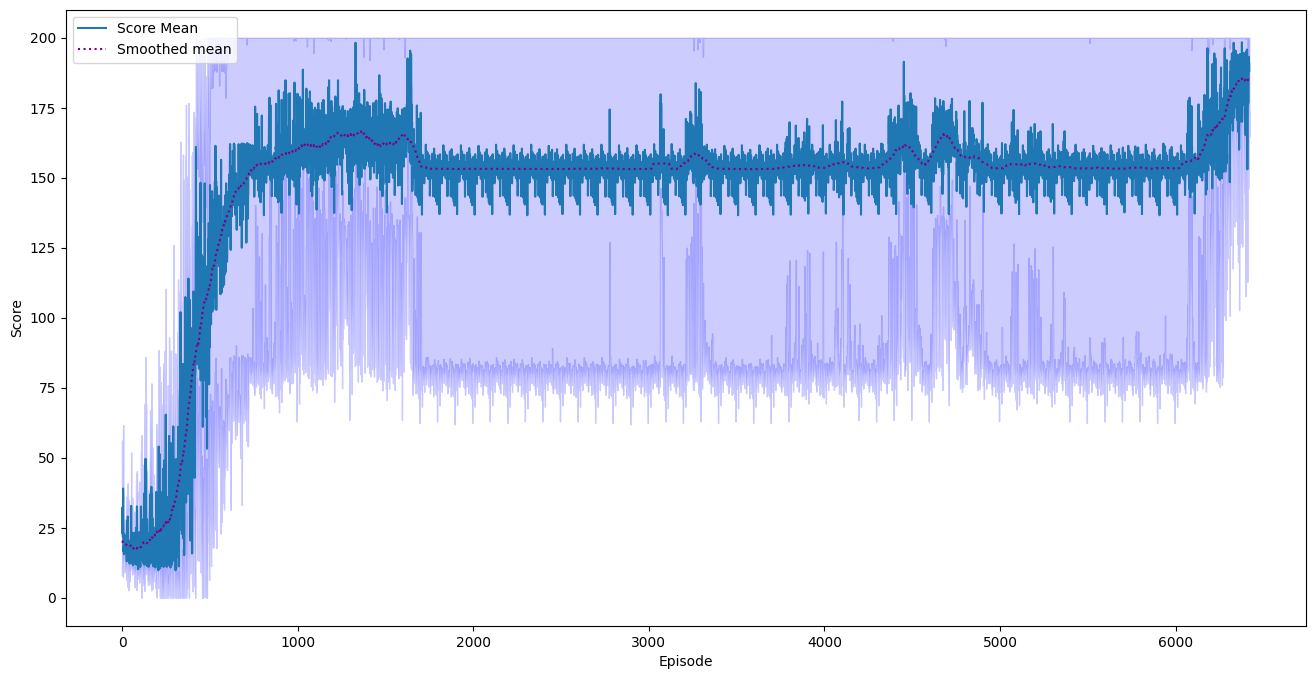

In [21]:
t = np.arange(0, maximum, 1)

# from scipy.interpolate import make_interp_spline # make smooth version
# interpol = make_interp_spline(t, score_mean, k=3)  # type: BSpline

fig, ax = plt.subplots(figsize=(16, 8))
ax.fill_between(t, np.maximum(score_mean - score_std, 0),
                np.minimum(score_mean + score_std, 200), color='b', alpha=0.2)
# ax.legend(loc='upper right')
ax.set_xlabel('Episode')
ax.set_ylabel('Score')
# ax.set_title('Inverted Pendulum Training Plot from Pixels')
ax.plot(t, score_mean, label='Score Mean')
ax.plot(t, last100_mean, color='purple', linestyle='dotted', label='Smoothed mean')
ax.legend()

plt.show()